In [196]:
import numpy as np
from math import pi
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from time import clock
from astropy.io import fits
import glob
import urllib.request
import os.path

from ppxf_wrap import ppxf_wrap
%matplotlib inline

#print(plt.rcParams['figure.figsize'])
plt.rcParams['figure.figsize'] = [9, 6]

# from ppxf import ppxf
# import ppxf_util as util

In [114]:
# class ppxf_wrap():
#     def __init__(self, redshift, wave, specres):
#         wave=wave/(1+redshift) #  When measure velocity from IFS observation, 
#                                         # deredshift to the barycenter should be applied before measuement.
#         specres=specres/(1+redshift)

# # Only use the wavelength range in common between galaxy and stellar library.
# #         mask = (t['loglam'] > np.log10(3540)) & (t['loglam'] < np.log10(7409))     
#         mask = (wave > 3540) & (wave < 7409)
#         loglam_gal = np.log10(wave[mask])
#         lam_gal = wave[mask]
#         specres=specres[mask]

#         c = 299792.458                  # speed of light in km/s
#         frac = lam_gal[1]/lam_gal[0]    # Constant lambda fraction per pixel
#         fwhm_gal=lam_gal/specres          # Resolution FWHM of every pixel, in Angstroms
#         velscale = np.log(frac)*c       # Constant velocity scale in km/s per pixel

#         file_dir='./'
#         galaxy_templates=glob.glob(file_dir+'Mun1.30Z*.fits')
#         fwhm_tem=2.51 # Vazdekis+10 spectra have a constant resolution FWHM of 2.51A.
#         hdu = fits.open(galaxy_templates[0])
#         ssp = hdu[0].data
#         h2 = hdu[0].header
#         lam_temp = h2['CRVAL1'] + h2['CDELT1']*np.arange(h2['NAXIS1'])
#         lamRange_temp = [np.min(lam_temp), np.max(lam_temp)]
#         sspNew = util.log_rebin(lamRange_temp, ssp, velscale=velscale)[0]
#         templates = np.empty((sspNew.size, len(galaxy_templates)))
#         dv = np.log(lam_temp[0]/lam_gal[0])*c    # km/s

#         fwhm_gal = np.interp(lam_temp, lam_gal, fwhm_gal)        
#         fwhm_dif = np.sqrt((fwhm_gal**2 - fwhm_tem**2).clip(0))
#         sigma = fwhm_dif/2.355/h2['CDELT1'] # Sigma difference in pixels

#         for j, fname in enumerate(galaxy_templates):
#             hdu = fits.open(fname)
#             ssp = hdu[0].data
#             ssp = util.gaussian_filter1d(ssp, sigma)  # perform convolution with variable sigma
#             sspNew = util.log_rebin(lamRange_temp, ssp, velscale=velscale)[0]
#             templates[:, j] = sspNew/np.median(sspNew) # Normalizes templates

#         self.templates=templates
#         self.flux=None
#         self.ivar=None
#         self.specres=specres
#         self.mask=mask
#         self.lam_gal=lam_gal
#         self.dv=dv
#         self.lamRange_temp=lamRange_temp
#         self.velscale=velscale

#     def run(self):
#         flux=(self.flux)[self.mask]
#         noise=(self.ivar**(-0.5))[self.mask]

#         specres=self.specres
#         templates=self.templates
#         lam_gal=self.lam_gal
#         nmask=(np.isfinite(noise) & (noise > 0))
#         dv=self.dv
#         velscale=self.velscale


#         flux = flux[nmask]
#         galaxy = flux/np.median(flux)   # Normalize spectrum to avoid numerical issues
#         noise = noise[nmask]/np.median(flux)
#         lam_gal=lam_gal[nmask]
#         goodpixels = util.determine_goodpixels(np.log(lam_gal), self.lamRange_temp, 0)

# # Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
# #         vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
#         start = [0, 200.]  # (km/s), starting guess for [V, sigma]

#         adegree=0
#         mdegree=0
#         pp=ppxf(templates, galaxy, noise, velscale, start,
#                   goodpixels=goodpixels, plot=False, quiet=True, moments=2,
#                   degree=adegree, mdegree=mdegree, vsyst=dv, clean=False, lam=lam_gal)
#         self.fflux=galaxy
#         return pp


In [70]:
plateifu='8329-6103'
print(plateifu.split('-'))
plate, ifuname=plateifu.split('-')
print(plate)
print(ifuname)

['8329', '6103']
8329
6103


---
## Download MaNGA Data & Catalog
Download MaNGA cube data and catalog from SDSS-IV DR14 Science Archieve Server (https://data.sdss.org/sas/dr14/)

* MaNGA data access <https://www.sdss.org/dr14/manga/manga-data/data-access/>

We use logarithmically-binned cube data

In [135]:
# plateifu of galaxy to download data
plateifu='8329-6103'

plate, ifuname=plateifu.split('-')
cdir='./'  #current directory

# MaNGA cube file
cube_file='manga-'+plateifu+'-LOGCUBE.fits.gz'   # file to de downloaded

# download MaNGA cube file if not exist.
if not os.path.isfile(cdir+cube_file):
    sas_url="https://data.sdss.org/sas/dr14/manga/spectro/redux/v2_1_2/"
    print("Start downloading "+cube_file+" from SDSS server. This may take several minutes")
    urllib.request.urlretrieve(sas_url+plate+'/stack/'+cube_file, cdir+cube_file)
    print('Downloaded complete')


# MaNGA Catalog file (DR14)
drpall_file="drpall-v2_1_2.fits"

# download drpall file if not exist.
if not os.path.isfile(cdir+drpall_file):
    sas_url="https://data.sdss.org/sas/dr14/manga/spectro/redux/v2_1_2/"
    print("Start downloading "+drpall_file+" from SDSS server. This may take several seconds")
    urllib.request.urlretrieve(sas_url+"drpall-v2_1_2.fits", cdir+drpall_file)    
    print('Downloaded complete')
    
image_file=plateifu+'.png'
if not os.path.isfile(cdir+image_file):
    sas_url="https://data.sdss.org/sas/dr14/manga/spectro/redux/v2_1_2/"
    print("Start downloading "+image_file+" from SDSS server. This may take several seconds")
    urllib.request.urlretrieve(sas_url+plate+'/stack/images/'+ifuname+'.png', cdir+image_file)
    print('Downloaded complete')
    
http://skyserver.sdss.org/dr14/en/tools/chart/navi.aspx?ra=213.103435454&dec=44.4608684501&scale=0.2

fig=plt.figure(figsize=(4,4), dpi=200)
plt.imshow(mpimg.imread(cdir+image_file),aspect='equal')
plt.axis('off')


Start downloading drpall-v2_1_2.fits from SDSS server. This may take several seconds
https://data.sdss.org/sas/dr14/manga/spectro/redux/v2_1_2/8329/stack/image/6103.png


---
## Read galaxy information
In this tutorial, we need information of galaxy on
* Redshift(z)
* B/A ratio (inclination)
* Position Angle (PA)

MaNGA catalog file (drpall-v2_1_2.fits) contains above information for each galaxy.

In [161]:
drpall=fits.open(cdir+drpall_file)
tbdata=drpall[1].data
idx=np.where(tbdata['plateifu'] == plateifu)
objra=tbdata['objra'][idx][0]
objdec=tbdata['objdec'][idx][0]
nsa_z=tbdata['nsa_z'][idx][0]
nsa_elpetro_phi=tbdata['nsa_elpetro_phi'][idx][0]
nsa_elpetro_ba=tbdata['nsa_elpetro_ba'][idx][0]

print("Galaxy: ",plateifu)
print("RA, DEC:", objra, ',',objdec)
print("Redshift: ",nsa_z)
print("Position angle: ", nsa_elpetro_phi)
print("b/a ratio: ", nsa_elpetro_ba)
print('More info: http://skyserver.sdss.org/dr14/en/tools/chart/navi.aspx?ra=%0.6f&dec=%0.6f&scale=0.2' % (objra, objdec))

# print(tbdata.columns.names)

Galaxy:  8329-6103
RA, DEC: 213.103435454 , 44.4608684501
Redshift:  0.0312672
Position angle:  28.8381
b/a ratio:  0.641807
More info: http://skyserver.sdss.org/dr14/en/tools/chart/navi.aspx?ra=213.103435&dec=44.460868&scale=0.2


---
## Read galaxy cube data
Read and explore MaNGA Cube data
In this tutorial, we are going to
- Plot galaxy spectrum at particular spaxel
- Plot galaxy intensity map

In [167]:
# Open and read flux, inverse variance, and mask cube.
cube = fits.open(cdir+cube_file)
flux=np.transpose(cube['FLUX'].data, axes=(2, 1, 0))
ivar=np.transpose(cube['IVAR'].data, axes=(2, 1, 0))
mask = np.transpose(cube['MASK'].data, axes=(2, 1, 0))
wave = cube['WAVE'].data
specres = cube['SPECRES'].data

flux_header = cube['FLUX'].header

### Plot galaxy spectrum
* Plot galaxy spectrum at the galaxy center.
* User can plot other part by changing x_plot and y_plot

[9.0, 6.0]


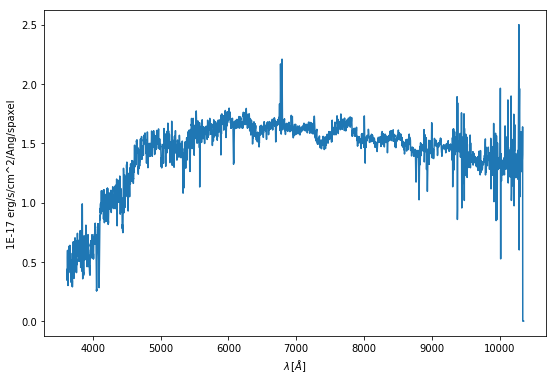

Cube 2D size:  54 by 54


In [194]:
#plot manga spectrum at the center
x_center = np.int(flux_header['CRPIX1']) - 1
y_center = np.int(flux_header['CRPIX2']) - 1

x_plot=x_center
y_plot=y_center

# User can plot other part of the galaxy
#x_plot=28
#y_plot=35

plt.rcParams['figure.figsize'] = [9, 6]

#fig=plt.figure(figsize=(6,4), dpi=200)
plt.plot(wave, flux[x_plot, y_plot])
print(plt.rcParams['figure.figsize'])
# plt.close()

#plt.figsize=plt.rcParams['figure.figsize']*4

plt.xlabel('$\lambda \, [\AA]$')
plt.ylabel(flux_header['BUNIT'])
plt.show()
print('Cube 2D size: ', flux.shape[0], 'by', flux.shape[1])

## Plot galaxy intensity map around Halpha
* Integrate spectrum flux around H alpha (6563 Angstrom)line. 
    * restframe 6550 to 6680 Angstrom
* Plot intensity map

Text(0,0.5,'arcsec')

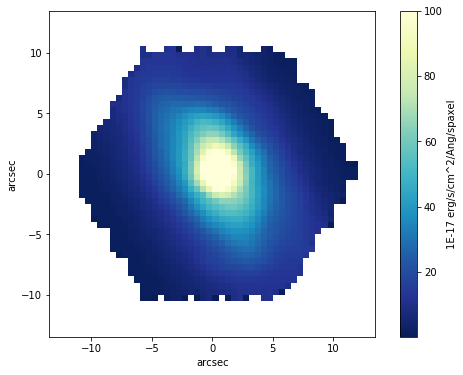

In [197]:
# process flux data 
do_not_use = (mask & 2**10) != 0
flux_m = np.ma.array(flux, mask=do_not_use)
ivar_m = np.ma.array(ivar, mask=do_not_use)

min_wave=6550
max_wave=6680
redshift = nsa_z
ind_wave = np.where((wave / (1 + redshift) > min_wave) & (wave / (1 + redshift) < max_wave))[0]
halpha = flux_m[:, :, ind_wave].sum(axis=2) # integrate flux along wavelength vector
im = halpha.T #Transpose numpy array

# Convert from array indices to arcsec relative to IFU center
dx = flux_header['CD1_1'] * 3600.  # deg to arcsec
dy = flux_header['CD2_2'] * 3600.  # deg to arcsec
x_extent = (np.array([0., im.shape[0]]) - (im.shape[0] - x_center)) * dx * (-1)
y_extent = (np.array([0., im.shape[1]]) - (im.shape[1] - y_center)) * dy
extent = [x_extent[0], x_extent[1], y_extent[0], y_extent[1]]

plt.imshow(im, extent=extent, cmap=cm.YlGnBu_r, vmin=0.1, vmax=100, origin='lower', interpolation='none')
plt.colorbar(label=flux_header['BUNIT'])
plt.xlabel('arcsec')
plt.ylabel('arcsec')

---
## Extract galaxy kinematics
* We use Penalized Pixel-Fitting method (pPXF) developed by Michele Cappellari to extract stellar kinematics of galaxy. 
    * http://www-astro.physics.ox.ac.uk/~mxc/software/#ppxf
    * pPXF in Python(v6.7.1) is included in this tutorial package. (ppxf.py and ppxf_util.py)
* pPXF fits template spectrum to the given galaxy spectrum to fit the galaxy kinematics.
* Four galaxy templates from MILES library is used in this tutorial.
    * Vazdekis (2010, MNRAS, 404, 1639) http://miles.iac.es/.
    * Metalicity (log(Z/Z_solar)=0), age: 1 Gyr, 2 Gyr, 8 Gyr, and 10 Gyr
        * Mun1.30Zp0.00T01.0000_iPp0.00_baseFe_linear_FWHM_2.51.fits
        * Mun1.30Zp0.00T07.9433_iPp0.00_baseFe_linear_FWHM_2.51.fits
        * Mun1.30Zp0.00T01.9953_iPp0.00_baseFe_linear_FWHM_2.51.fits
        * Mun1.30Zp0.00T10.0000_iPp0.00_baseFe_linear_FWHM_2.51.fits

* The warpper of pPXF is written separatly in ppxf_wrap.py.

### Measure line of sight velocity using ppxf_wrap
* To measure velocity in your own machine, set run_vel_measure = True
* Below code will show measured velocity at each spaxel one by one.
* Result will be saved in FITS format.

/home/hchung/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in power
/home/hchung/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


17 04   -214.170    120.625  0.90  0.3
18 04     66.077      0.690  0.92  0.4
19 04    199.196    862.126  0.77  0.1
23 04    344.692      0.690  0.81  0.3
15 05   1311.634   1000.000  0.83  0.2
16 05    210.914    333.751  0.91  0.3
17 05    210.428    323.423  0.91  0.5
18 05    209.811    325.738  0.90  0.2
19 05    204.932    328.762  0.90  0.1
20 05     74.957    323.311  0.91  0.4
21 05    163.738     37.294  0.90  0.3
22 05    161.820     44.268  0.91  0.5
23 05    163.896     48.165  0.91  0.6
24 05    165.900     52.146  0.92  0.6
25 05    169.086     56.170  0.92  1.3
26 05    -43.594    602.974  0.98  0.4
27 05    233.966     39.239  0.97  0.3
28 05    236.160     38.121  0.97  0.3
29 05    238.399     41.777  0.98  1.2
30 05    250.400     28.024  0.99  0.4
31 05   2000.000      0.690  0.80  0.1
32 05    240.680      0.690  0.94  0.2
33 05    240.144      0.690  0.94  0.6
34 05    239.670      0.690  0.93  0.3
35 05    238.358      0.690  0.89  0.4
37 05    248.971     10.1

43 11    228.482     25.882  0.95  0.6
10 12    263.520    163.496  0.97  0.7
11 12    274.416     55.101  0.97  0.9
12 12    291.250     95.667  0.98  0.8
13 12    239.651    134.900  1.06  0.3
14 12    146.909    135.066  1.13  0.5
15 12    114.998    112.395  1.11  0.4
16 12    130.969     67.135  1.10  0.6
17 12    137.838      0.690  1.01  0.4
18 12    144.627      0.690  0.99  0.2
19 12    144.357      0.690  0.99  0.6
20 12    145.425      0.690  0.96  0.5
21 12    157.571     17.457  1.03  0.3
22 12    170.912     25.623  1.10  0.4
23 12    180.587     16.621  1.14  0.3
24 12    183.940      3.109  1.21  0.3
25 12    185.671      0.690  1.15  0.4
26 12    194.310      0.690  1.15  0.5
27 12    203.467      0.690  1.14  0.5
28 12    211.086      0.690  1.14  0.4
29 12    218.494     13.128  1.20  0.3
30 12    223.854      9.475  1.26  0.7
31 12    230.274     11.126  1.28  0.4
32 12    233.271      0.690  1.29  0.3
33 12    235.804      0.690  1.25  0.5
34 12    238.594      0.6

32 17    228.274      0.690  1.59  0.3
33 17    232.958      0.690  1.50  0.7
34 17    235.558      0.690  1.63  0.3
35 17    236.092      0.690  1.55  0.6
36 17    233.716      0.690  1.52  0.4
37 17    225.417      0.690  1.63  0.3
38 17    216.331      0.690  1.35  0.4
39 17    211.141      0.690  1.13  0.3
40 17    209.093      0.690  1.07  0.2
41 17    207.734      0.690  1.18  0.3
42 17    204.585      0.690  1.33  0.3
43 17    202.292     27.289  1.19  0.2
44 17    201.427     42.821  1.09  0.2
45 17    203.514     48.869  1.05  0.4
46 17    207.245     51.828  1.00  0.2
07 18    121.628      0.690  0.91  0.7
08 18    176.132     90.055  0.95  0.2
09 18    184.210    103.696  0.96  0.4
10 18    183.684     68.545  1.02  0.4
11 18    193.368     57.423  1.12  0.5
12 18    179.065     42.101  1.10  0.2
13 18    159.919     16.874  1.07  1.1
14 18    132.954      0.690  1.03  0.6
15 18    117.671      0.690  0.99  0.5
16 18    112.482      0.690  1.05  0.2
17 18    111.217      0.6

26 22    152.455     54.704  1.80  0.8
27 22    171.039     53.082  1.95  0.6
28 22    185.387     55.798  1.88  0.3
29 22    192.771     44.325  1.74  0.5
30 22    196.989     35.865  1.73  1.2
31 22    199.348     31.794  1.65  0.3
32 22    201.771     27.092  1.63  0.4
33 22    203.682     23.448  1.47  0.2
34 22    201.323     34.557  1.46  0.6
35 22    195.853     34.238  1.50  0.4
36 22    190.919     39.140  1.35  0.3
37 22    185.632     29.839  1.36  0.4
38 22    181.344      9.125  1.22  0.5
39 22    179.299      8.345  1.23  0.3
40 22    179.403     15.930  1.21  0.8
41 22    180.166     25.779  1.11  0.4
42 22    179.469     23.789  1.06  0.4
43 22    177.075     32.533  0.99  0.5
44 22    169.717     18.653  1.08  0.4
45 22    161.921      0.690  1.11  0.6
46 22    154.797      0.690  1.06  0.3
47 22    149.901      0.690  1.04  0.7
48 22    147.758      0.690  1.03  0.6
49 22    153.942    246.384  0.81  0.4
04 23     43.008    493.853  0.93  0.2
05 23     21.910     48.8

43 26    144.969     14.866  1.12  0.4
44 26    146.527      0.690  1.05  0.5
45 26    148.016      0.690  0.99  0.3
46 26    148.678      0.690  1.04  0.4
47 26    145.114      0.690  1.16  0.2
48 26    138.678     14.277  1.11  0.4
49 26    129.625     38.412  1.05  0.3
50 26    127.548     52.157  1.04  1.4
51 26    135.400     65.345  0.98  0.3
02 27    -87.663    173.927  0.92  0.1
03 27    -59.570    185.953  0.93  0.9
04 27     17.264    208.262  0.97  0.1
05 27    -46.768      0.690  1.07  0.4
06 27    -31.970      0.690  1.09  0.3
07 27    -23.183      0.690  1.03  0.6
08 27      3.750     11.956  1.03  0.2
09 27     32.046     12.477  1.02  0.2
10 27     46.420     12.613  1.04  0.3
11 27     46.732     17.087  1.07  0.4
12 27     44.956     27.614  1.01  0.2
13 27     43.481     37.479  0.99  0.2
14 27     43.309     36.300  1.02  0.2
15 27     42.397     37.881  1.06  0.4
16 27     44.734     23.813  1.16  0.2
17 27     48.168     24.229  1.15  0.2
18 27     50.186     25.1

10 31     31.935     26.357  1.03  0.3
11 31     24.367     49.781  0.97  0.4
12 31     18.747     55.984  0.96  0.2
13 31     20.341     43.177  1.08  0.1
14 31     24.392     22.570  1.17  0.4
15 31     23.256     16.282  1.21  0.2
16 31     18.415     15.214  1.22  0.2
17 31     12.229     19.072  1.17  0.3
18 31      6.518     20.821  1.31  0.3
19 31      5.306     18.459  1.48  0.2
20 31      2.474     27.903  1.57  0.2
21 31     -1.203     35.903  1.61  0.2
22 31     -2.194     41.375  1.67  0.2
23 31     -0.561     54.695  1.74  0.3
24 31      2.642     59.212  2.05  0.6
25 31      7.517     63.260  2.13  0.4
26 31     14.536     65.718  2.20  0.5
27 31     28.938     74.150  1.96  0.2
28 31     40.121     74.415  1.86  0.7
29 31     45.810     65.349  2.00  0.2
30 31     54.812     55.118  2.00  0.2
31 31     63.844     43.592  1.93  0.2
32 31     68.186     43.679  1.51  0.2
33 31     73.175     41.510  1.24  0.3
34 31     77.493     45.518  1.28  0.8
35 31     81.479     35.7

47 35    103.823    167.347  0.97  0.7
48 35     92.453    111.171  0.91  0.6
07 36    -10.338     58.001  0.89  0.3
08 36     -9.990     50.731  0.90  0.5
09 36     -9.421     45.840  0.94  0.3
10 36    -13.413     38.669  1.05  0.3
11 36    -16.558     22.936  1.17  0.2
12 36    -20.681      1.103  1.17  0.2
13 36    -24.079      0.690  1.22  0.2
14 36    -26.809      0.690  1.32  0.2
15 36    -29.357      0.690  1.34  0.2
16 36    -30.439      0.690  1.43  0.2
17 36    -32.893      0.690  1.29  0.2
18 36    -37.934      0.690  1.31  0.3
19 36    -43.157      0.690  1.38  0.2
20 36    -47.967      0.690  1.33  0.2
21 36    -50.595      0.690  1.40  0.4
22 36    -50.544      0.690  1.35  0.3
23 36    -47.948      0.690  1.35  0.2
24 36    -41.835     11.463  1.39  0.4
25 36    -34.694     14.184  1.32  0.7
26 36    -24.442     18.395  1.38  0.4
27 36    -17.529     10.712  1.35  0.6
28 36     -9.475     16.403  1.31  0.5
29 36     -1.686     13.210  1.38  0.6
30 36      5.788     26.8

/home/hchung/exercise/manga_rc_tuto/capfit.py:137: RuntimeWarning: invalid value encountered in double_scalars
  ratio = actred/prered


10 41    -32.934      2.356  0.97  0.6
11 41    -32.753      2.791  0.96  0.4
12 41    -36.389      4.655  1.03  0.4
13 41    -42.447      5.486  1.11  0.2
14 41    -48.445      0.690  1.12  0.2
15 41    -52.075      0.690  1.15  0.3
16 41    -55.133      0.690  1.22  0.2
17 41    -59.810      0.690  1.23  0.7
18 41    -62.574      0.690  1.21  0.2
19 41    -63.312      0.690  1.15  0.2
20 41    -63.573      0.690  1.10  0.3
21 41    -63.023      0.690  1.13  0.3
22 41    -61.354     17.890  1.14  0.2
23 41    -54.483     30.647  1.12  0.2
24 41    -42.622     29.422  1.13  0.1
25 41    -32.340     23.817  1.09  0.3
26 41    -26.160     21.577  1.13  0.3
27 41    -24.179     24.395  1.11  0.2
28 41    -20.493     21.912  1.15  0.1
29 41    -16.311      0.690  1.18  0.2
30 41    -11.767      0.690  1.14  0.2
31 41     -5.644      0.690  1.19  0.3
32 41      0.366     12.237  1.25  0.1
33 41     13.783     27.043  1.31  0.5
34 41     31.611      0.690  1.45  0.1
35 41     43.246      0.6

33 47     -2.993     46.944  0.93  0.3
34 47     -0.946     56.708  0.96  0.1
35 47      8.721     93.035  1.11  0.1
36 47     84.591    339.051  0.99  0.2
37 47   -537.344    590.754  0.95  0.5
38 47   -634.164    654.363  0.94  0.6
39 47   -574.519    689.322  0.94  1.0
40 47   -593.089    540.421  0.94  0.8
41 47     80.856    490.560  0.84  0.2
15 48    -88.126     96.105  0.93  0.1
16 48    -87.100      0.690  1.01  1.0
17 48    -86.710      0.690  1.01  0.3
18 48    -86.280      0.690  1.01  0.4
19 48    -85.855      0.690  1.00  0.8
20 48    -27.638     93.016  0.92  0.3
21 48    -57.222     24.729  0.97  0.7
22 48    -57.889     27.536  0.97  0.3
23 48    -58.496     30.188  0.97  1.4
24 48    -58.967     32.599  0.97  0.3
25 48    -53.363    318.197  0.94  0.2
26 48    -31.438      0.690  0.93  0.2
27 48    -31.123      0.690  0.93  0.5
28 48    -30.773      0.690  0.94  0.2
29 48    -30.391      0.690  0.94  0.2
30 48    -22.712     85.908  0.96  0.2
31 48     -1.278     43.2

Text(0,0.5,'1E-17 erg/s/cm^2/Ang/spaxel')

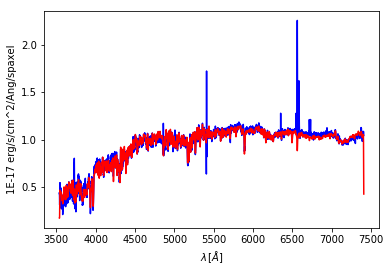

In [14]:
run_vel_measure=False

oname=cdir+'manga-'+plateifu+'-LOGCUBE_MAPS.fits'

check_i=27
check_j=27

def plot_fit(ppxf_obj, result):
    plt.plot(ppxf_obj.lam_gal, ppxf_obj.fflux, 'b-')
    plt.plot(ppxf_obj.lam_gal, result.bestfit, 'r-')
    plt.xlabel('$\lambda \, [\AA]$')
    plt.ylabel(flux_header['BUNIT'])

if run_vel_measure:
    ppxf_obj=ppxf_wrap(0.031267200, wave, specres)
    np.set_printoptions(threshold=np.nan)
    nx, ny, _ = flux.shape
    resarr=np.zeros((nx,ny))
    flagarr=np.zeros((nx,ny),dtype=np.int16) #define flag array
    t = clock()
    check_flag=False
    print("%2s %2s %10s %10s %5.2f %4.1f" % ('i', 'j', 'Velocity', 'Dispersion', 'Chi2', 't')
    for j in range(nx):
          for i in range(ny):
          t = clock()
          if np.median(flux_m[i,j]) > 0:
              ppxf_obj.flux=flux_m[i,j]
              ppxf_obj.ivar=ivar_m[i,j]
              res=ppxf_obj.run()
              resarr[i,j]=res.sol[0]
              flagarr[i,j]=1
              if i == check_i & j == check_j:
                  check_flag=True
                  sflux=ppxf_obj.fflux
                  sbestfit=res.bestfit
              print("%02d %02d %10.3f %10.3f %5.2f %4.1f" % (i, j, res.sol[0], res.sol[1], res.chi2, clock()-t))

    if check_flag:
          plt.plot(ppxf_obj.lam_gal, sflux, 'b-')
          plt.plot(ppxf_obj.lam_gal, sbestfit, 'r-')
          plt.xlabel('$\lambda \, [\AA]$')
          plt.ylabel(flux_header['BUNIT'])
          
    print('Save velocity measurement data in to FITS file: ', oname)
    hdu = fits.PrimaryHDU()
    hdu.writeto(oname, overwrite=True)

    fits.append(oname, resarr)
    fits.append(oname, flagarr.astype(np.int16))

    append_file=fits.open(oname, mode='update')

    hdr=append_file[1].header
    hdr.set('EXTNAME','STELLAR_VEL')
    hdr=append_file[2].header
    hdr['EXTNAME']='FLAG'

    append_file.close()

## Read and 2D velocity map
* Use pre-saved file when user skipped the previous part.

Text(0,0.5,'arcsec')

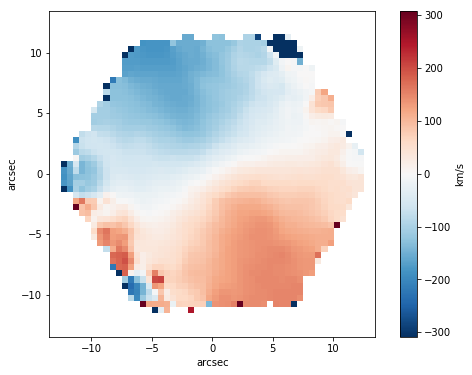

In [221]:
# read velocity map file
files=glob.glob('./'+'*.fits*')
rfile=cdir+'manga-'+plateifu+'-LOGCUBE_MAPS.fits'
if not (rfile in files): # use pre-saved file if above one not exist.
    rfile=cdir+'manga-'+plateifu+'-LOGCUBE_MAPS_SAVED.fits'
    
cube = fits.open(rfile)
velmap=cube['STELLAR_VEL'].data
nx, ny=np.int(flux_header['NAXIS1']) , np.int(flux_header['NAXIS2'])

# Plot 2D map
# Calculate velocity statistics (median and standard deviation) to re-scale map values for plot)
pvelmap=velmap.T
finite_idx=np.isfinite(pvelmap)
medv, stdv, sigv=(np.median(pvelmap[finite_idx]), np.std(pvelmap[finite_idx]), 2)
pvelmap=pvelmap-medv

cmap= matplotlib.cm.RdBu_r
cmap.set_bad(color='white')
plt.imshow(pvelmap, extent=extent, cmap=cmap, vmin=(-stdv*sigv), vmax=stdv*sigv, origin='lower', interpolation='none')
plt.colorbar(label='km/s')
plt.xlabel('arcsec')
plt.ylabel('arcsec')

## Plot rotation curve
![gal_rot](./gal_rot.png)

(-14.258777525364602, 14.075146026809914)

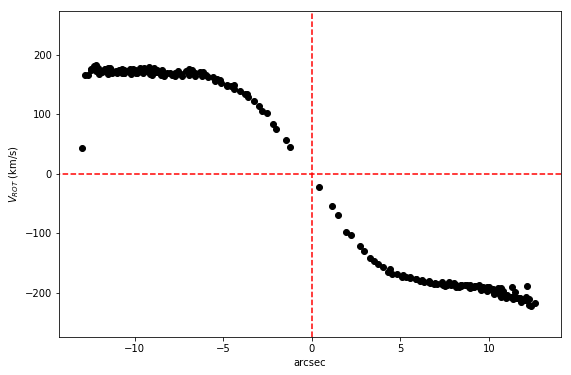

In [293]:
aidx=np.arange(nx*ny)

ix=aidx % nx
iy=aidx // ny

incl=np.arccos(nsa_elpetro_ba)
phi0=(nsa_elpetro_phi+90)/180*pi
cent_x, cent_y = 0, 0

incl=1.0487251 
phi0=0.49254251+pi/2
cent_x, cent_y = 0.46911, 0.451718

x_obs=(ix-(nx/2-0.5))*0.5
y_obs=(iy-(ny/2-0.5))*0.5
r_obs=((x_obs-cent_x)**2+(y_obs-cent_y)**2)**0.5

tan_half_phi_obs=((y_obs-cent_y)/(x_obs-cent_x+r_obs))

phi_obs=2*np.arctan(tan_half_phi_obs)
tan_phi_gal=np.tan(phi_obs-phi0)/np.cos(incl)
cos_phi_gal=1/((1+tan_phi_gal**2)**0.5)
r_gal=r_obs*np.cos(phi_obs-phi0)/cos_phi_gal

v_rot=pvelmap.flatten()/cos_phi_gal/np.sin(incl)

max_angle=20
major_idx=np.flatnonzero(np.abs((phi_obs-phi0)/pi*180 % 180 ) < max_angle)
r_gal=r_gal[major_idx]
v_rot=v_rot[major_idx]

yamp=np.max(v_rot[np.isfinite(np.abs(v_rot))])*1.5
xamp=np.max(r_gal[np.isfinite(np.abs(r_gal))])*1
plt.plot(r_gal, v_rot, 'ko')
xlim=plt.xlim()
plt.plot([-xamp, xamp], [0,0], 'r--')
plt.plot([0,0], [-yamp,yamp], 'r--')

plt.xlabel('arcsec')
plt.ylabel('$V_{ROT}$ (km/s) ')
# print(v_rot[np.isfinite(v_rot)])
plt.ylim([-yamp,yamp])
plt.xlim(xlim)